<center><img src='cookie_cats_img.jpg' height='200' width='600'/></center>

## 1. Importing and checking the data

We are going to perform an A/B testing analysis on data from the mobile game "Cookie Cats". As the player progresses in this game, before accesing certain levels, there are "gates" that force them to wait a non-trivial amount of time before accesing the next level, prompting them to make an in-app purchase if they want to continue to the next level. 

In this case, we have data of two groups of users in which the gate was set on level 30 and level 40 respectively, and we want to assess which one is better in retention terms

In [1]:
#importing necessary libraries
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, normaltest, anderson
from numpy.random import seed
from statsmodels.stats.power import zt_ind_solve_power
from statsmodels.stats.weightstats import ztest

In [2]:
#Importing the data and having a look at the first rows

df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


The data we have is from 90,189 players that installed the game while the AB-test was running. Let's quickly summarize columns:
* userid: int that identifies the user at hand
* version: wether they are finding the gate at level 30 (control group) or 40 (test group)
* sum_gamerounds: the number of game rounds played by the player during the first 14 days after install.
* retention_1: did the player come back and play 1 day after installing?
* retention_7: did the player come back and play 7 days after installing?

A quick sanity check that we can do is that the number of users in both groups is roughly the same, since this minimizes variance of the estimates and maximizes power:

In [3]:
#% of users in each group
df.groupby('version')['userid'].count()/len(df)

version
gate_30    0.495626
gate_40    0.504374
Name: userid, dtype: float64

0.9125835744935635

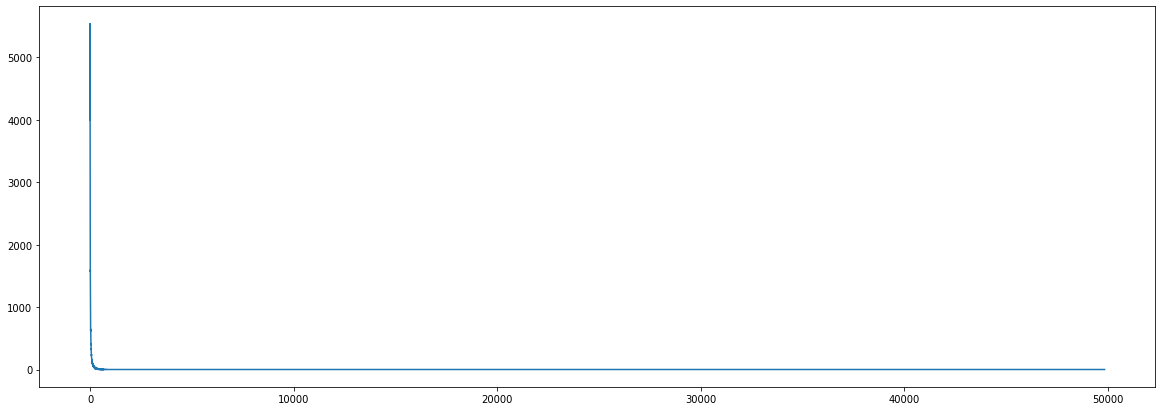

In [4]:
#It seems the vast majority of users have played less than 150 rounds, although there are others who have played thousands (if there are no mistakes in the data)
df.sum_gamerounds.value_counts().sort_index().plot(figsize=(20, 7))
len(df[df.sum_gamerounds < 150]) / len(df)

Text(0.5, 0, 'Sum game rounds')

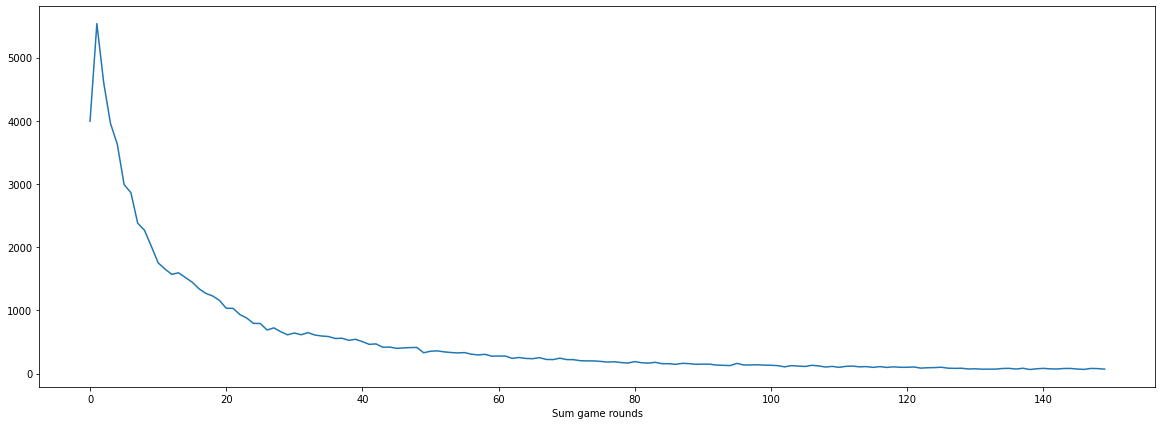

In [5]:
#It would be more informative to visualize the count of users who have played less than 150 rounds:
ax = df.loc[df.sum_gamerounds < 150, 'sum_gamerounds'].value_counts().sort_index().plot(kind='line', figsize=(20, 7))
ax.set_xlabel('Sum game rounds')

Text(0.5, 0, 'Sum game rounds')

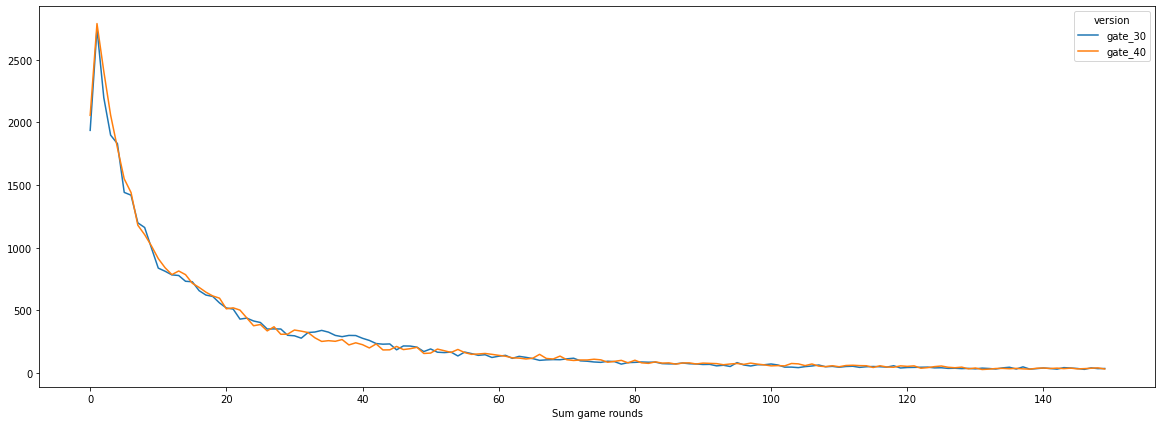

In [6]:
#This distribution should be roughly the same between versions, since they should have been randomly sampled
ax = pd.pivot_table(data=df[df.sum_gamerounds < 150], values='userid', index='sum_gamerounds', columns='version', aggfunc='count').plot(figsize=(20, 7))
ax.set_xlabel('Sum game rounds')

It seems the distribution of other variables apart from retention (in this case, only sum_gamerounds) does not change with version, so the sample seems to be random

## 2. Checking the difference in 1-day and 7-days retention

From the data above, we can see than the level of engagement of users vary greatly: most of them don't play a lot and there are others who really get hooked. Of course is in the interest of the company to maximize retenttion both in the first day (ie. % of players who come back and play 1 day after the game has been installed). Let's see if there is difference between control and test groups here:

In [7]:
df.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

In [8]:
df.groupby('version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

At first sight it seems that players with the gate in the 30th level achieve greater retention. Although it is only a 0.6% decrease, very small changes in retention can have a big impact in the business when there are a lot of players. However, can we be confident about the difference? First of all we have to obtain a sampling distribution of the means. We will repeatedly re-sample our dataset (with replacement) and calculate 1-day retention for those samples. The variation in 1-day and 7-days retentions will give us an indication of how uncertain the retention numbers are.

In [17]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
boot_7d = []
for i in range(10000):
    boot_mean_1d = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_mean_7d = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean_1d)
    boot_7d.append(boot_mean_7d)
# Transforming the lists to a DataFrames
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

### Method 1: Simulation

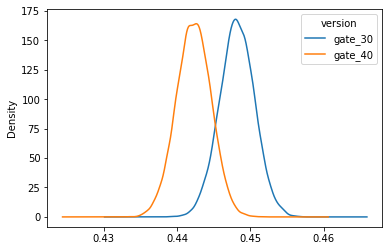

In [18]:
# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot(kind='kde')

The plots above represent the bootstrap distributions of retention mean for both groups. Just by looking at them, it seems there is a appreciable (although small) difference between them. We can compute their % difference and estimate the chance that this is 0.

Text(0.5, 0, 'relative diff density estimation')

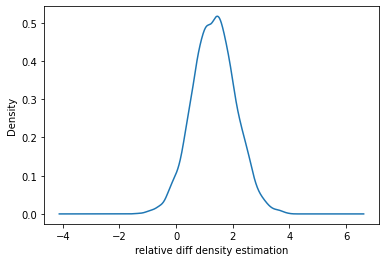

In [19]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = (boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot(kind='kde')
ax.set_xlabel("relative diff density estimation")

In [20]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob = len(boot_1d[boot_1d['diff'] > 0]) / len(boot_1d)
# Pretty printing the probability
print(f'Probability that both means are not equal {prob*100:.2f}%')

Probability that both means are not equal 96.04%


Let's encapsulate this within a function that we could use to check the probability of not being equal with the retention_7 distributions

In [21]:
def boot_test(boot):
    fig, axs = plt.subplots(2,1, figsize=(20, 15))
    # Plot distributions
    boot = pd.DataFrame(boot)
    boot.plot(kind='kde', ax=axs[0])
    # Plot differences
    boot['diff'] = (boot['gate_30'] - boot['gate_40']) / boot['gate_40'] * 100
    ax = boot['diff'].plot(kind='kde', ax=axs[1])
    ax.set_xlabel("relative diff density estimation")
    prob = len(boot[boot['diff'] > 0]) / len(boot)
    print(f'Probability that both means are not equal is {prob*100:.2f}%')

Probability that both means are not equal is 99.94%


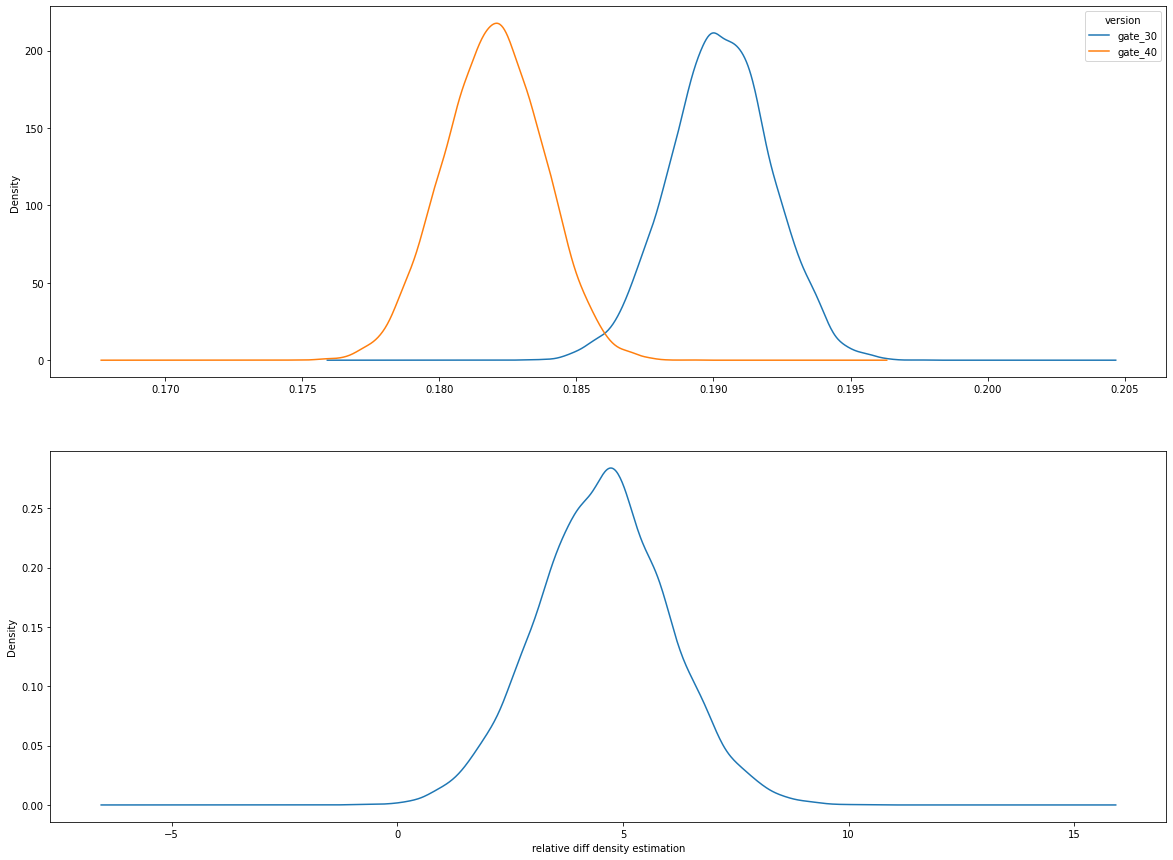

In [22]:
boot_test(boot_7d)

As we can see graphically and analytically, the difference here is greater and the prob of these means not being equal is very high

### Method 2: Z-test

Because of the way we have built our boot_1d / boot_7d dataframes (sampling distribution from df), taking into account the [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) we know that its columns are going to be normally distributed, but let's check that with some tests:

In [23]:
def wether_gaussian(array,verbose=False):
    # Seed the random number generator
    seed(1)
    # Normality tests
    shapiro_stat, shapiro_p = shapiro(array)
    dagostino_stat, dagostino_p = normaltest(array)
    anderson_stat, anderson_cv_array, anderson_sl_array = anderson(array)
    if verbose:
        print(f'Shapiro statistics={shapiro_stat:.3f}, p={shapiro_p:.3}')
        print(f'D\'Agostino statistics={dagostino_stat:.3f}, p={dagostino_p:.3}')
        print(f'Anderson statistics={anderson_stat:.3f}, p={anderson_cv_array[-1]:.3}')
    # Interpret
    alpha = 0.05
    if shapiro_p > alpha and dagostino_p > alpha and anderson_stat < anderson_cv_array[-1]:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')
wether_gaussian(boot_1d.gate_30)
wether_gaussian(boot_1d.gate_40)
wether_gaussian(boot_7d.gate_30)
wether_gaussian(boot_7d.gate_40)

Sample looks Gaussian (fail to reject H0)
Sample looks Gaussian (fail to reject H0)
Sample looks Gaussian (fail to reject H0)
Sample looks Gaussian (fail to reject H0)


/home/alvfermar/miniconda3/envs/ab_testing/lib/python3.8/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Now let's try to determine if there is a statistically significant difference between the two groups using and hypothesis test (two-sided Z-test). First, let's define the null and alternative hypotheses:

* Ho: 1-day conversion rate is equal in both groups
* Ha: 1-day conversion rate is different in both groups


Since we have the sample size of 44700, we want to detect a relatively small effect (sensitivity of the test) of 2% and want a significance level of 5%, we can calculate the statistical power of the test. Let's remember some definitions:
* Sensitivity level/effect size --> the minimum detectable difference between the metrics). The higher the sensitivity the higher the needed sample size
* Statistical power --> the probability of not making a type II error, this is rejecting the null hypothesis when it should actually be rejected. The higher the statistical power the higher the needed sample size
* Confidence level --> the probability of not making a type I error, this is accepting the null hypothesis when it should actually be accepted. The higher the confidence level the higher the needed sample size

In [24]:
power = zt_ind_solve_power(effect_size=0.02, nobs1=len(df[df.version == 'gate_30']), alpha=0.05, power=None, 
                           ratio=len(df[df.version == 'gate_30'])/len(df[df.version == 'gate_40']), 
                           alternative='two-sided')
print(f'With the above conditions, the statistical power, this is the ability of correctly rejecting the null hypothesis is {power:.4f}.\n' 
      f'This means we will correctly reject Ho {power*100:.2f}% of the times')

With the above conditions, the statistical power, this is the ability of correctly rejecting the null hypothesis is 0.8454.
This means we will correctly reject Ho 84.54% of the times


Now let's run a Z-test and compare with the desired alpha level to see if differences are statistically significant

In [25]:
_, pvalue = ztest(boot_1d.gate_30, boot_1d.gate_40)
if pvalue < 0.05:
    print('The difference is statistically significant')

The difference is statistically significant


Let's encapsulate this within a function that we could use to check with a Z-test the statistical significance of retentions in both groups not being equal. There will be differences in effect_size and bootstrap df:

In [27]:
def ztest_test(effect_size, df, boot):
    power = zt_ind_solve_power(effect_size=effect_size, nobs1=len(df[df.version == 'gate_30']), alpha=0.05, power=None, 
                           ratio=len(df[df.version == 'gate_30'])/len(df[df.version == 'gate_40']), 
                           alternative='two-sided')
    print(f'With the above conditions, the statistical power, this is the ability of correctly rejecting the null hypothesis is {power:.4f}.\n' 
          f'This means we will correctly reject Ho {power*100:.2f}% of the times')
    _, pvalue = ztest(boot.gate_30, boot.gate_40)
    if pvalue < 0.05:
        print('The difference is statistically significant')

In [28]:
ztest_test(0.05, df, boot_7d)

With the above conditions, the statistical power, this is the ability of correctly rejecting the null hypothesis is 1.0000.
This means we will correctly reject Ho 100.00% of the times
The difference is statistically significant


## 3.Conclusion

As we can see, in case 2 the difference is so big that we reject Ho and conclude means are different.

Looking at the results, we can conclude that **moving the payment gate from level 30 to 40 has a negative effect on 1-day but above all on 7-day retention.** If we want to maximize retention, then we should NOT move the payment gate to level 40 